In [1]:
import os
from datetime import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

import hephaestus.single_row_models as sr

# Load and preprocess the dataset (assuming you have a CSV file)
df = pd.read_csv("./data/diamonds.csv")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [2]:
dataset = sr.TabularDS(df, target_column="price")

In [3]:
print("Numeric Shape:", dataset.X_train_numeric[0:2].shape)
print("Categorical Shape:", dataset.X_train_categorical[0:2].shape)

Numeric Shape: torch.Size([2, 6])
Categorical Shape: torch.Size([2, 3])


In [4]:
model = sr.TabTransformer(dataset, n_heads=8).to(dataset.device)

batch_size = 3
test_num = dataset.X_train_numeric[0:batch_size, :]
test_num_mask = sr.mask_tensor(test_num, model)
test_cat = dataset.X_test_categorical[0:batch_size, :]
test_cat_mask = sr.mask_tensor(test_cat, model)
with torch.no_grad():
    x = model(
        test_num_mask,
        test_cat_mask,
        task="mlm",
    )
x[0].shape, x[1].shape

(torch.Size([3, 9, 33]), torch.Size([3, 6]))

In [5]:
# sr.show_mask_pred(0, model, dataset, probability=0.8)

In [6]:
# Masked Tabualr Modeling
base_model_name = "is_model_global2"

model_time = dt.now()
model_time = model_time.strftime("%Y-%m-%dT%H:%M:%S")
model_name = f"{base_model_name}_{model_time}"

model_save_path = "./checkpoints/mtm_models_small.pt"

In [7]:
model_list = os.listdir("./checkpoints")
if model_save_path.split("/")[-1] in model_list:
    print("Model already exists")
    model_exists = True
else:
    print("Model does not exist")
    model_exists = False

if model_exists:
    model.load_state_dict(torch.load(model_save_path))
else:
    sr.mtm(model, dataset, model_name, epochs=100, batch_size=1000, lr=0.001)
    torch.save(model.state_dict(), model_save_path)

Model already exists


In [8]:
# regression_performance = sr.fine_tune_model(
#     model, dataset, model_name="FT100", n_rows=100, epochs=100
# )
# regression_performance

In [9]:
n_train_rows = [
    # 10,
    100,
    1_000,
    2_000,
    5_000,
    10_000,
    15_000,
    30_000,
    # 40_000,
    dataset.X_train.shape[0],
]

In [10]:
def train_multiple_sizes(pt_model_path, dataset, n_train_rows, n_epochs=100):
    model = sr.TabTransformer(dataset, n_heads=8).to(dataset.device)
    if pt_model_path is not None:
        model.load_state_dict(torch.load(pt_model_path))

    regression_performance = sr.fine_tune_model(
        model,
        dataset,
        model_name=f"ft_{n_train_rows}",
        n_rows=n_train_rows,
        epochs=n_epochs,
    )

    return regression_performance

In [11]:
hephaestus_results_no_pre_train = []
pbar = tqdm(n_train_rows)
for i in pbar:
    pbar.set_description(f"n_rows: {i}")
    loss = train_multiple_sizes(None, dataset, i, n_epochs=250)
    hephaestus_results_no_pre_train.append(loss)

  0%|          | 0/8 [00:00<?, ?it/s]

Epochs, Model: ft_100_100_2025-03-14T13:39:36:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_1000_1000_2025-03-14T13:40:19:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_2000_2000_2025-03-14T13:41:34:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_5000_5000_2025-03-14T13:42:07:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_10000_10000_2025-03-14T13:42:46:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_15000_15000_2025-03-14T13:44:03:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_30000_30000_2025-03-14T13:45:38:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_43152_43152_2025-03-14T13:49:49:   0%|          | 0/250 [00:00<?, ?it/s]

In [12]:
no_pt_df = pd.DataFrame(hephaestus_results_no_pre_train)
no_pt_df["model"] = "Hephaestus No Fine Tune"
no_pt_df

,n_rows,test_loss,model
0,100,1.499163e+06,Hephaestus No Fine Tune
1,1000,6.643138e+05,Hephaestus No Fine Tune
2,2000,5.043709e+05,Hephaestus No Fine Tune
3,5000,4.112977e+05,Hephaestus No Fine Tune
4,10000,3.692085e+05,Hephaestus No Fine Tune
5,15000,3.568800e+05,Hephaestus No Fine Tune
6,30000,3.388109e+05,Hephaestus No Fine Tune
7,43152,3.011905e+05,Hephaestus No Fine Tune


In [13]:
hephaestus_results = []
pbar = tqdm(n_train_rows)
for i in pbar:
    pbar.set_description(f"n_rows: {i}")
    loss = train_multiple_sizes(model_save_path, dataset, i, n_epochs=250)
    hephaestus_results.append(loss)

  0%|          | 0/8 [00:00<?, ?it/s]

Epochs, Model: ft_100_100_2025-03-14T13:54:57:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_1000_1000_2025-03-14T13:55:29:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_2000_2000_2025-03-14T13:56:09:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_5000_5000_2025-03-14T13:56:51:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_10000_10000_2025-03-14T13:57:39:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_15000_15000_2025-03-14T13:58:49:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_30000_30000_2025-03-14T14:01:31:   0%|          | 0/250 [00:00<?, ?it/s]

Epochs, Model: ft_43152_43152_2025-03-14T14:05:13:   0%|          | 0/250 [00:00<?, ?it/s]

In [14]:
hephaestus_df = pd.DataFrame(hephaestus_results)
hephaestus_df["model"] = "Hephaestus"
hephaestus_df

,n_rows,test_loss,model
0,100,1.213683e+06,Hephaestus
1,1000,6.903626e+05,Hephaestus
2,2000,4.876963e+05,Hephaestus
3,5000,4.122396e+05,Hephaestus
4,10000,3.835530e+05,Hephaestus
5,15000,3.625138e+05,Hephaestus
6,30000,3.238301e+05,Hephaestus
7,43152,3.043666e+05,Hephaestus


In [15]:
hephaestus_df.loc[hephaestus_df.n_rows == 1000, "test_loss"].values

array([690362.625])

In [16]:
diamonds_data = pd.read_csv("./data/diamonds.csv")

# Encode categorical features using LabelEncoder
label_encoders = {}
categorical_features = ["cut", "color", "clarity"]
for feature in categorical_features:
    le = LabelEncoder()
    diamonds_data[feature] = le.fit_transform(diamonds_data[feature])
    label_encoders[feature] = le

# Split the dataset into features (X) and target (y)
X = diamonds_data.drop("price", axis=1)
y = diamonds_data["price"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the XGBoost regressor
xgb_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_regressor.fit(
    X_train[0:batch_size],
    y_train[0:batch_size],
)

# Predict on the test set
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:,.2f}")

# You can also access feature importance scores
# feature_importances = xgb_regressor.feature_importances_
# print("Feature Importance:")
# for feature, importance in zip(X.columns, feature_importances):
#     print(f"{feature}: {importance:.4f}")

Mean Squared Error: 11,076,718.00


In [17]:
def xgb_tester(train_set_size):
    xgb_regressor = XGBRegressor(n_estimators=120, learning_rate=0.1, random_state=42)
    xgb_regressor.fit(
        X_train[0:train_set_size],
        y_train[0:train_set_size],
    )

    y_pred = xgb_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return {"n_rows": train_set_size, "test_loss": mse}


xgb_losses = []
for i in tqdm(n_train_rows):
    mse = xgb_tester(i)
    xgb_losses.append(mse)

  0%|          | 0/8 [00:00<?, ?it/s]

In [18]:
xgb_df = pd.DataFrame(xgb_losses)
xgb_df["model"] = "XGBoost"

xgb_df

,n_rows,test_loss,model
0,100,1.676436e+06,XGBoost
1,1000,6.923195e+05,XGBoost
2,2000,4.986939e+05,XGBoost
3,5000,3.832898e+05,XGBoost
4,10000,3.403952e+05,XGBoost
5,15000,3.205772e+05,XGBoost
6,30000,2.992576e+05,XGBoost
7,43152,2.815193e+05,XGBoost


In [19]:
loss_df = pd.concat([hephaestus_df, xgb_df, no_pt_df])  # , no_pt_df
loss_df = loss_df.loc[loss_df["n_rows"] != 10]
loss_df.sample(10)

,n_rows,test_loss,model
2,2000,5.043709e+05,Hephaestus No Fine Tune
6,30000,3.388109e+05,Hephaestus No Fine Tune
1,1000,6.903626e+05,Hephaestus
3,5000,3.832898e+05,XGBoost
6,30000,2.992576e+05,XGBoost
3,5000,4.112977e+05,Hephaestus No Fine Tune
0,100,1.499163e+06,Hephaestus No Fine Tune
3,5000,4.122396e+05,Hephaestus
4,10000,3.403952e+05,XGBoost
2,2000,4.876963e+05,Hephaestus


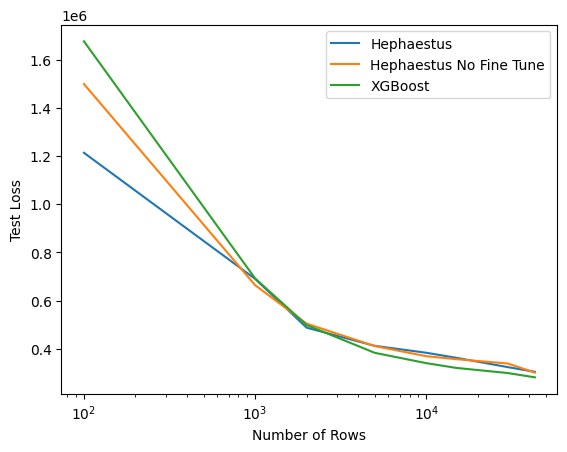

In [20]:
# Define the colors for each model
# colors = {"Hephaestus": "blue", "XGBoost": "red"}

# Create a figure and axis object
fig, ax = plt.subplots()

# Loop through each model and plot the test loss as a line
for model, group in loss_df.groupby("model"):
    ax.plot(group["n_rows"], group["test_loss"], label=model)

# Set the axis labels and legend
ax.set_xlabel("Number of Rows")
ax.set_ylabel("Test Loss")
ax.legend()
# set x axis to log scale
ax.set_xscale("log")

# Show the plot
plt.show()

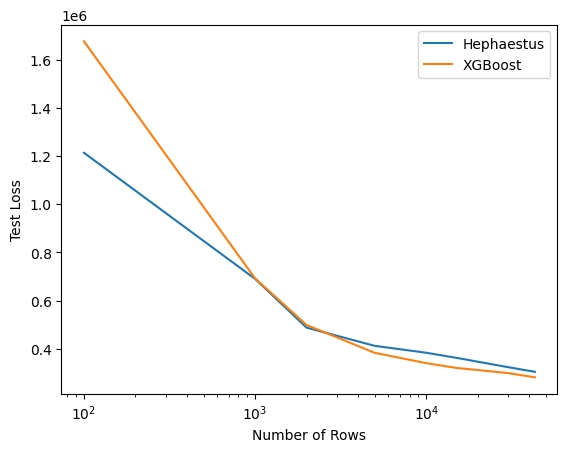

In [21]:
# Define the colors for each model
# colors = {"Hephaestus": "blue", "XGBoost": "red"}

# Create a figure and axis object
fig, ax = plt.subplots()

# Loop through each model and plot the test loss as a line
for model, group in loss_df.loc[loss_df["model"] != "Hephaestus No Fine Tune"].groupby(
    "model"
):
    ax.plot(group["n_rows"], group["test_loss"], label=model)

# Set the axis labels and legend
ax.set_xlabel("Number of Rows")
ax.set_ylabel("Test Loss")
ax.legend()
# set x axis to log scale
ax.set_xscale("log")

# Show the plot
plt.show()

In [22]:
# Spread the data to have columns for the loss of each model
# loss_df =
loss_percent_df = loss_df.pivot(
    index="n_rows", columns="model", values="test_loss"
).reset_index()
loss_percent_df["percent_improvement"] = (
    loss_percent_df["XGBoost"] - loss_percent_df["Hephaestus"]
) / loss_percent_df["XGBoost"]

In [23]:
loss_percent_df

model,n_rows,Hephaestus,Hephaestus No Fine Tune,XGBoost,percent_improvement
0,100,1.213683e+06,1.499163e+06,1.676436e+06,0.276034
1,1000,6.903626e+05,6.643138e+05,6.923195e+05,0.002827
2,2000,4.876963e+05,5.043709e+05,4.986939e+05,0.022053
3,5000,4.122396e+05,4.112977e+05,3.832898e+05,-0.075530
4,10000,3.835530e+05,3.692085e+05,3.403952e+05,-0.126787
5,15000,3.625138e+05,3.568800e+05,3.205772e+05,-0.130816
6,30000,3.238301e+05,3.388109e+05,2.992576e+05,-0.082111
7,43152,3.043666e+05,3.011905e+05,2.815193e+05,-0.081157


(array([  100,  1000,  2000,  5000, 10000, 15000, 30000, 43152]),
 [Text(100, 0, '100'),
  Text(1000, 0, '1000'),
  Text(2000, 0, '2000'),
  Text(5000, 0, '5000'),
  Text(10000, 0, '10000'),
  Text(15000, 0, '15000'),
  Text(30000, 0, '30000'),
  Text(43152, 0, '43152')])

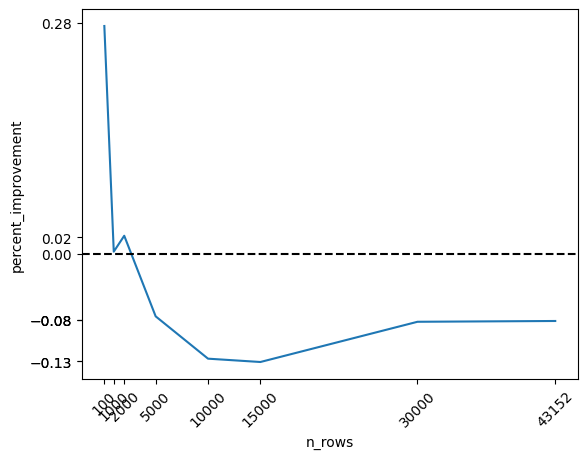

In [24]:
ax = sns.lineplot(data=loss_percent_df, x="n_rows", y="percent_improvement")
plt.axhline(y=0, color="black", linestyle="--")
ax.set_yticks(loss_percent_df["percent_improvement"].round(2))
ax.set_xticks(loss_percent_df["n_rows"])
# ax.set_xscale("log")
# X lables at 45 degree angle
plt.xticks(rotation=45)
# plt.xlabel